In [1]:
import gym
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 1000
env.action_space.n, env.observation_space.shape

(3, (2,))

In [3]:
env.action_space, env.observation_space

(Discrete(3), Box([-1.2  -0.07], [0.6  0.07], (2,), float32))

In [4]:
# Testing on random actions
env.reset()
done = False
score = 0
frames = []

while not done:
    action = env.action_space.sample()
    new_state, reward, done, info = env.step(action)
    
    score += reward
    frames.append(Image.fromarray(env.render(mode="rgb_array")))
    
print(f"Total reward is: {score}")
env.close()

C:\Users\Petar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Total reward is: -1000.0


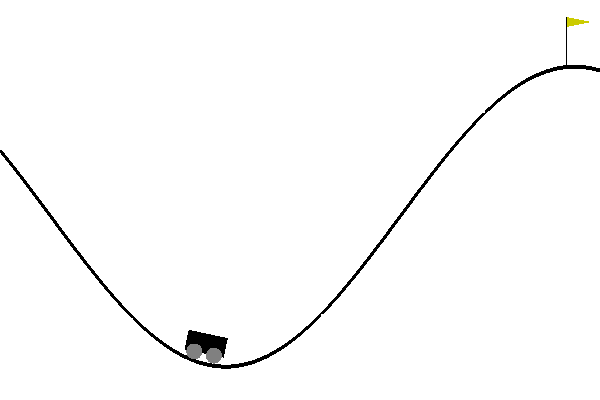

In [5]:
frames[0]

In [6]:
# Creating a gif
frames[0].save("MountainCar Q Learning Before Training Random Movement.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

In [7]:
env.observation_space.sample()

array([0.19903757, 0.06437709], dtype=float32)

In [8]:
env.observation_space.low, env.observation_space.high

(array([-1.2 , -0.07], dtype=float32), array([0.6 , 0.07], dtype=float32))

In [9]:
position_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
velocity_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)

In [10]:
position_space

array([-1.20000005, -1.1052632 , -1.01052636, -0.91578951, -0.82105266,
       -0.72631582, -0.63157897, -0.53684213, -0.44210528, -0.34736843,
       -0.25263159, -0.15789474, -0.0631579 ,  0.03157895,  0.12631579,
        0.22105264,  0.31578949,  0.41052633,  0.50526318,  0.60000002])

In [11]:
velocity_space

array([-0.07      , -0.06263158, -0.05526316, -0.04789474, -0.04052632,
       -0.03315789, -0.02578947, -0.01842105, -0.01105263, -0.00368421,
        0.00368421,  0.01105263,  0.01842105,  0.02578947,  0.03315789,
        0.04052632,  0.04789474,  0.05526316,  0.06263158,  0.07      ])

In [12]:
# We want to transform continues observation state into discrete observation space
# Here we use bucket system where we if we have buckets [0, 1, 2] and value 1.324 it will be transformed to 1
# in other scenario where we have value 2.5 it will be transformed into 2
def get_state(observation):
    position, velocity = observation
    position_bin = int(np.digitize(position, position_space))
    velocity_bin = int(np.digitize(velocity, velocity_space))

    return position_bin, velocity_bin

In [13]:
def get_max_action(Q_table, state, actions=[0, 1, 2]):
    values = np.array([Q_table[state, action] for action in actions])
    max_action = np.argmax(values)

    return max_action

In [14]:
NUM_ITERATIONS = 30000
LR = 0.1 # Try 0.01 or even 0.01
DISCOUNT_FACTOR = 0.95 # Try 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
ACTION_SPACE = [action for action in range(env.action_space.n)]

In [15]:
# Creating state list where we have tuples of each part (velocity and position) that creates observation space
states = []
for position in range(len(position_space)+1):
    for velocity in range(len(velocity_space)+1):
        states.append((position, velocity))

In [16]:
# Creating Q table, basically giving a value to state-action dictionary
Q_table = {}
for state in states:
    for action in ACTION_SPACE:
        Q_table[state, action] = 0

In [17]:
score_history, epsilon_history = [], []
epsilon = EPSILON_START

for iteration in range(NUM_ITERATIONS):
    done = False
    obs = env.reset()
    state = get_state(obs)
    
    score = 0
    while not done:
        if np.random.random() >= epsilon:
            action = get_max_action(Q_table, state, ACTION_SPACE)
        else:
            action = np.random.choice(ACTION_SPACE)
        
        new_obs, reward, done, _ = env.step(action)
        new_state = get_state(new_obs)
        
        score += reward
        
        new_action = get_max_action(Q_table, new_state, ACTION_SPACE)
        Q_table[state, action] = Q_table[state, action] + LR * (reward + DISCOUNT_FACTOR * Q_table[new_state, new_action] - Q_table[state, action])
        
        state = new_state

    if iteration % 1000 == 0 and iteration != 0:
        print(f"Episode: {iteration}, Score: {score}, Epsilon: {epsilon}")
    
    score_history.append(score)
    epsilon_history.append(epsilon)
    epsilon = epsilon - 2 / NUM_ITERATIONS if epsilon > EPSILON_END else EPSILON_END
    

Episode: 1000, Score: -1000.0, Epsilon: 0.9333333333333407
Episode: 2000, Score: -1000.0, Epsilon: 0.8666666666666814
Episode: 3000, Score: -644.0, Epsilon: 0.800000000000022
Episode: 4000, Score: -704.0, Epsilon: 0.7333333333333627
Episode: 5000, Score: -488.0, Epsilon: 0.6666666666667034
Episode: 6000, Score: -495.0, Epsilon: 0.600000000000044
Episode: 7000, Score: -324.0, Epsilon: 0.5333333333333847
Episode: 8000, Score: -230.0, Epsilon: 0.4666666666667254
Episode: 9000, Score: -300.0, Epsilon: 0.4000000000000661
Episode: 10000, Score: -311.0, Epsilon: 0.33333333333340676
Episode: 11000, Score: -238.0, Epsilon: 0.26666666666674743
Episode: 12000, Score: -158.0, Epsilon: 0.2000000000000881
Episode: 13000, Score: -224.0, Epsilon: 0.13333333333342878
Episode: 14000, Score: -151.0, Epsilon: 0.06666666666675732
Episode: 15000, Score: -151.0, Epsilon: 0.01
Episode: 16000, Score: -161.0, Epsilon: 0.01
Episode: 17000, Score: -144.0, Epsilon: 0.01
Episode: 18000, Score: -157.0, Epsilon: 0.01

In [18]:
# Testing
obs = env.reset()
state = get_state(obs)
done = False
score = 0
frames = []

while not done:
    action = get_max_action(Q_table, state)
    new_obs, reward, done, _ = env.step(action)
    score += reward
    
    new_state = get_state(new_obs)
    state = new_state
    frames.append(Image.fromarray(env.render(mode="rgb_array")))
    
print(f"Total rewards is: {score}")
env.close()

Total rewards is: -160.0


In [19]:
# Creating a gif
frames[0].save("MountainCar Q Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

In [39]:
def plot_training(x_label, y_label, values, legend_labels, colors, average_freq, xlim, ylim, figsize=(12, 10), filename=None):
    assert len(values) == len(legend_labels) == len(colors)
    
    # Creating a figure
    fig = plt.figure(figsize=figsize)
    plt.xlabel(x_label, color="black")
    plt.ylabel(y_label, color="black")
    
    for value, label, color in zip(values, legend_labels, colors):
        value_len = len(value)
        running_average = np.empty(value_len)
        for timestep in range(average_freq, value_len):
            running_average[timestep] = np.mean(value[timestep-average_freq:timestep+1])
        
        plt.plot([x_value for x_value in range(value_len)], running_average, color=color, label=label)
        
    plt.xlim(1, xlim)
    plt.ylim(ylim, 0)
    plt.legend()

    # Save if needed
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

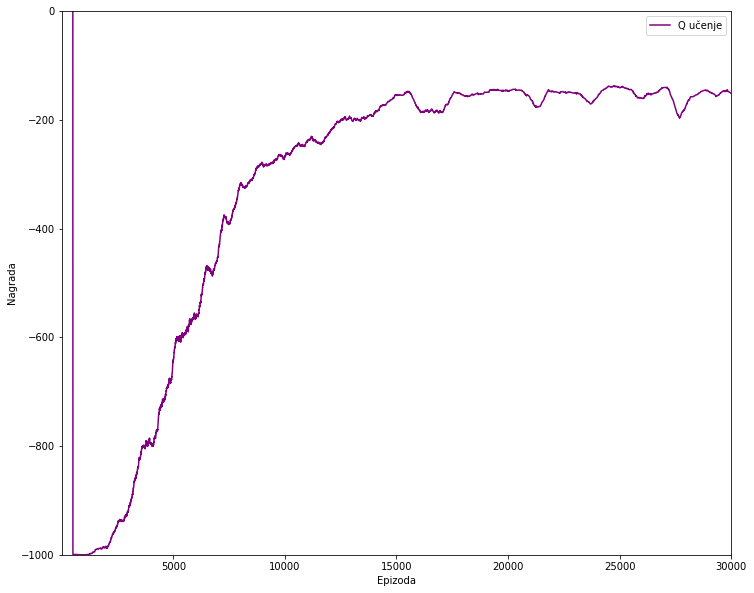

In [43]:
plot_training("Episode", "Reward", [score_history], ["Q Learning"], ["purple"], 500, NUM_ITERATIONS, -1000, filename="Q learning on MountainCar.png")